In [1]:
# Python core
from typing import Optional, Callable, TypedDict, Union, Iterable, Tuple, NamedTuple, List
from dataclasses import dataclass
import datetime
from itertools import product
from concurrent import futures

# Scientific python
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import pytorch_lightning as pl
import random

In [2]:
Array = Union[np.ndarray, xr.DataArray]
IMAGE_ATTR_NAMES = ('historical_ERA5_images', 'target_ERA5_images')

class Sample(TypedDict):
    """Simple class for structuring data for the ML model.
    
    Using typing.TypedDict gives us several advantages:
      1. Single 'source of truth' for the type and documentation of each example.
      2. A static type checker can check the types are correct.

    Instead of TypedDict, we could use typing.NamedTuple,
    which would provide runtime checks, but the deal-breaker with Tuples is that they're immutable
    so we cannot change the values in the transforms.
    """
    # IMAGES
    # Shape: batch_size, seq_length, lat, lon, lev
    historical_ERA5_images: Array
    target_ERA5_images: Array
        
    # METADATA
    datetime_index: Array

    
def get_forward_data(filename) -> xr.DataArray:
    """Lazily opens the Zarr store on gladefilesystem.
    """
    dataset = xr.open_zarr(filename)#, consolidated=True)
    return dataset


class Segment(NamedTuple):
    """Represents the start and end indicies of a segment of contiguous samples."""
    start: int
    end: int

In [3]:
def get_contiguous_segments(dt_index: pd.DatetimeIndex, min_timesteps: int, max_gap: pd.Timedelta) -> Iterable[Segment]:
    """Chunk datetime index into contiguous segments, each at least min_timesteps long.
    
    max_gap defines the threshold for what constitutes a 'gap' between contiguous segments.
    
    Throw away any timesteps in a sequence shorter than min_timesteps long.
    """
    gap_mask = np.diff(dt_index) > max_gap
    gap_indices = np.argwhere(gap_mask)[:, 0]

    # gap_indicies are the indices into dt_index for the timestep immediately before the gap.
    # e.g. if the datetimes at 12:00, 12:05, 18:00, 18:05 then gap_indicies will be [1].
    segment_boundaries = gap_indices + 1

    # Capture the last segment of dt_index.
    segment_boundaries = np.concatenate((segment_boundaries, [len(dt_index)]))

    segments = []
    start_i = 0
    for end_i in segment_boundaries:
        n_timesteps = end_i - start_i
        if n_timesteps >= min_timesteps:
            segment = Segment(start=start_i, end=end_i)
            segments.append(segment)
        start_i = end_i
        
    return segments


def get_zarr_chunk_sequences(
    n_chunks_per_disk_load: int, 
    zarr_chunk_boundaries: Iterable[int], 
    contiguous_segments: Iterable[Segment]) -> Iterable[Segment]:
    """
    
    Args:
      n_chunks_per_disk_load: Maximum number of Zarr chunks to load from disk in one go.
      zarr_chunk_boundaries: The indicies into the Zarr store's time dimension which define the Zarr chunk boundaries.
        Must be sorted.
      contiguous_segments: Indicies into the Zarr store's time dimension that define contiguous timeseries.
        That is, timeseries with no gaps.
    
    Returns zarr_chunk_sequences: a list of Segments representing the start and end indicies of contiguous sequences of multiple Zarr chunks,
    all exactly n_chunks_per_disk_load long (for contiguous segments at least as long as n_chunks_per_disk_load zarr chunks),
    and at least one side of the boundary will lie on a 'natural' Zarr chunk boundary.
    
    For example, say that n_chunks_per_disk_load = 3, and the Zarr chunks sizes are all 5:
    
    
                  0    5   10   15   20   25   30   35 
                  |....|....|....|....|....|....|....|

    INPUTS:
                     |------CONTIGUOUS SEGMENT----|
                     
    zarr_chunk_boundaries:
                  |----|----|----|----|----|----|----|
    
    OUTPUT:
    zarr_chunk_sequences:
           3 to 15:  |-|----|----|
           5 to 20:    |----|----|----|
          10 to 25:         |----|----|----|
          15 to 30:              |----|----|----|
          20 to 32:                   |----|----|-|
    
    """
    assert n_chunks_per_disk_load > 0
    
    zarr_chunk_sequences = []

    for contig_segment in contiguous_segments:
        # searchsorted() returns the index into zarr_chunk_boundaries at which contig_segment.start
        # should be inserted into zarr_chunk_boundaries to maintain a sorted list.
        # i_of_first_zarr_chunk is the index to the element in zarr_chunk_boundaries which defines
        # the start of the current contig chunk.
        i_of_first_zarr_chunk = np.searchsorted(zarr_chunk_boundaries, contig_segment.start)
        
        # i_of_first_zarr_chunk will be too large by 1 unless contig_segment.start lies
        # exactly on a Zarr chunk boundary.  Hence we must subtract 1, or else we'll
        # end up with the first contig_chunk being 1 + n_chunks_per_disk_load chunks long.
        if zarr_chunk_boundaries[i_of_first_zarr_chunk] > contig_segment.start:
            i_of_first_zarr_chunk -= 1
            
        # Prepare for looping to create multiple Zarr chunk sequences for the current contig_segment.
        zarr_chunk_seq_start_i = contig_segment.start
        zarr_chunk_seq_end_i = None  # Just a convenience to allow us to break the while loop by checking if zarr_chunk_seq_end_i != contig_segment.end.
        while zarr_chunk_seq_end_i != contig_segment.end:
            zarr_chunk_seq_end_i = zarr_chunk_boundaries[i_of_first_zarr_chunk + n_chunks_per_disk_load]
            zarr_chunk_seq_end_i = min(zarr_chunk_seq_end_i, contig_segment.end)
            zarr_chunk_sequences.append(Segment(start=zarr_chunk_seq_start_i, end=zarr_chunk_seq_end_i))
            i_of_first_zarr_chunk += 1
            zarr_chunk_seq_start_i = zarr_chunk_boundaries[i_of_first_zarr_chunk]
            
    return zarr_chunk_sequences


In [32]:
class ERA5Dataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        zarr_chunk_sequences,
        filename: str = '/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.zarr',
        history_len: int = 1,
        forecast_len: int = 2,
        transform: Optional[Callable] = None,
        n_disk_loads_per_epoch: int = 10_000,
        min_n_samples_per_disk_load: int = 1_000,
        max_n_samples_per_disk_load: int = 2_000,
        n_zarr_chunk_sequences_to_load_at_once: int = 3
    ):
        self.zarr_chunk_sequences = zarr_chunk_sequences
        self.filename = filename
        self.history_len = history_len
        self.forecast_len = forecast_len
        self.transform = transform
        self.n_disk_loads_per_epoch = n_disk_loads_per_epoch
        self.min_n_samples_per_disk_load = min_n_samples_per_disk_load
        self.max_n_samples_per_disk_load = max_n_samples_per_disk_load
        self.n_zarr_chunk_sequences_to_load_at_once = n_zarr_chunk_sequences_to_load_at_once
        
        self.total_seq_len = self.history_len + self.forecast_len
        self.data_array = get_forward_data(filename=self.filename)
        self.rng = np.random.default_rng(seed=torch.initial_seed())
    
    def __post_init__(self):
        #: Total sequence length of each sample.
        self.total_seq_len = self.history_len + self.forecast_len

    def __len__(self):
        return len(self.data_array['time'])-2

    def __getitem__(self, index):
        data_in_mem = self._load_data_from_disk()
        sample = self._get_sample(data_in_mem)
        if self.transform:
            sample = self.transform(sample)
        return sample

    def _load_data_from_disk(self) -> List[xr.DataArray]:
        """Loads data from contiguous Zarr chunks from disk into memory."""
        ERA5_images_list = []
        for _ in range(self.n_zarr_chunk_sequences_to_load_at_once):
            zarr_chunk_sequence = random.choice(self.zarr_chunk_sequences)
            ERA5_images = self.data_array.isel(time=slice(*zarr_chunk_sequence))
            # Sanity checks
            n_timesteps_available = len(ERA5_images)
            if n_timesteps_available < self.total_seq_len:
                raise RuntimeError(f'Not enough timesteps in loaded data!  Need at least {self.total_seq_len}.  Got {n_timesteps_available}!')

            ERA5_images_list.append(ERA5_images.load())
        return ERA5_images_list

    def _get_sample(self, data_in_mem_list: List[xr.DataArray]) -> Sample:
        i = np.random.choice(len(data_in_mem_list))
        data_in_mem = data_in_mem_list[i]
        n_timesteps_available = len(data_in_mem)
        max_start_idx = n_timesteps_available - self.total_seq_len
        start_idx = np.random.randint(0, max_start_idx, dtype=np.uint32)
        end_idx = start_idx + self.total_seq_len
        
        ERA5_images = data_in_mem.isel(time=slice(start_idx, end_idx))
        
        return Sample(
            historical_ERA5_images=ERA5_images.isel(time=slice(0, self.history_len)),
            target_ERA5_images=ERA5_images.isel(time=slice(self.history_len, None)),
            datetime_index=ERA5_images.time.values.astype('datetime64[s]').astype(int)
        )


In [33]:
class ToTensor():
    def __call__(self, sample: Sample) -> Sample:
        
        return_dict = {}
        
        for key, value in sample.items():
            
            if isinstance(value, xr.DataArray):
                value_var = value.values
                
            elif isinstance(value, xr.Dataset):
                surface_vars = 0
                concatenated_vars = []
                varsdo = ['U','V','T','Q','SP']
                for vv in varsdo: 
                    value_var = value[vv].values
                    if vv == 'SP':
                        surface_vars = np.expand_dims(value_var,axis=1)
                    else:
                        concatenated_vars.append(value_var)
                    
            else: 
                value_var = value        
                    
            if key == 'historical_ERA5_images':
                return_dict['x_surf'] = torch.from_numpy(surface_vars)
                return_dict['x'] = torch.from_numpy(np.vstack(concatenated_vars))
            elif key == 'target_ERA5_images':
                return_dict['y_surf'] = torch.from_numpy(surface_vars)
                return_dict['y'] = torch.from_numpy(np.hstack([np.expand_dims(x, axis=1) for x in concatenated_vars]))
                
        return return_dict

In [34]:
# datasets (zarr reader)
forcing_data = get_forward_data(filename='/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.zarr').unify_chunks()

In [35]:
#this could be a problem!: 
zarr_chunk_boundaries = np.concatenate(([0], np.cumsum(forcing_data.chunks['time'])))
Array = Union[np.ndarray, xr.DataArray]
IMAGE_ATTR_NAMES = ('historical_ERA5_images', 'target_ERA5_images')

datetimes = forcing_data.time.values
contiguous_segments = get_contiguous_segments(
    dt_index = datetimes,
    min_timesteps = 36 * 1.5,
    max_gap = pd.Timedelta('1 hour')
)
zarr_chunk_sequences = get_zarr_chunk_sequences(
    n_chunks_per_disk_load=1,
    zarr_chunk_boundaries=zarr_chunk_boundaries,
    contiguous_segments=contiguous_segments
)

In [36]:
dataset = ERA5Dataset(
    zarr_chunk_sequences=zarr_chunk_sequences, 
    transform=transforms.Compose([
            ToTensor(),
        ])
)

In [37]:
dataset.data_array.sel()

<xarray.Dataset>
Dimensions:     (time: 8808, level: 15, latitude: 640, longitude: 1280,
                 half_level: 138)
Coordinates:
  * half_level  (half_level) int32 1 2 3 4 5 6 7 ... 132 133 134 135 136 137 138
  * latitude    (latitude) float64 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
  * level       (level) int32 10 30 40 50 60 70 80 90 95 100 105 110 120 130 136
  * longitude   (longitude) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * time        (time) datetime64[ns] 2010-01-01 ... 2011-01-02T23:00:00
Data variables:
    Q           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    SP          (time, latitude, longitude) float32 dask.array<chunksize=(10, 320, 640), meta=np.ndarray>
    T           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    U           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    V           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
Attributes: (12/18)
    COMPUTATIONAL_PLATFORM:                 cheyenne supercomputer, NCAR-Wyom...
    COMPUTATIONAL_SPECIALIST:               Dave Stepaniak, NCAR/CISL/DECS, d...
    CONVERSION_AND_COMPRESSION_PLATFORM:    cheyenne node employed: Linux r2i...
    CONVERSION_AND_COMPRESSION_SPECIALIST:  Dave Stepaniak, NCAR/CISL/DECS, d...
    CONVERSION_AND_COMPRSSION_DATE:         Sat Dec 24 17:14:38 MST 2022
    Conventions:                            CF-1.6
    ...                                     ...
    NETCDF_VERSION:                         4.8.1
    RDA_DATASET:                            ds633.6
    RDA_DATASET_DOI:                        DOI: 10.5065/XV5R-5344
    RDA_DATASET_GROUP:                      ERA5 atmospheric model level anal...
    RDA_DATASET_URL:                        https:/rda.ucar.edu/datasets/ds63...
    history:                                Sat Dec 24 17:14:51 2022: ncks -4...

In [38]:
sample = dataset.__getitem__(0)

In [39]:
for key, val in sample.items():
    print(key, val.shape)

x_surf torch.Size([1, 1, 640, 1280])
x torch.Size([4, 15, 640, 1280])
y_surf torch.Size([2, 1, 640, 1280])
y torch.Size([2, 4, 15, 640, 1280])


In [16]:
data_in_mem = dataset._load_data_from_disk()

In [28]:
data_in_mem[6]

<xarray.Dataset>
Dimensions:     (time: 10, level: 15, latitude: 640, longitude: 1280,
                 half_level: 138)
Coordinates:
  * half_level  (half_level) int32 1 2 3 4 5 6 7 ... 132 133 134 135 136 137 138
  * latitude    (latitude) float64 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
  * level       (level) int32 10 30 40 50 60 70 80 90 95 100 105 110 120 130 136
  * longitude   (longitude) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * time        (time) datetime64[ns] 2010-02-28T08:00:00 ... 2010-02-28T17:0...
Data variables:
    Q           (time, level, latitude, longitude) float32 3.449e-06 ... 0.00...
    SP          (time, latitude, longitude) float32 1.036e+05 ... 6.896e+04
    T           (time, level, latitude, longitude) float32 233.7 233.7 ... 232.1
    U           (time, level, latitude, longitude) float32 15.97 15.97 ... -4.46
    V           (time, level, latitude, longitude) float32 0.5156 ... -5.986
Attributes: (12/18)
    COMPUTATIONAL_PLATFORM:                 cheyenne supercomputer, NCAR-Wyom...
    COMPUTATIONAL_SPECIALIST:               Dave Stepaniak, NCAR/CISL/DECS, d...
    CONVERSION_AND_COMPRESSION_PLATFORM:    cheyenne node employed: Linux r2i...
    CONVERSION_AND_COMPRESSION_SPECIALIST:  Dave Stepaniak, NCAR/CISL/DECS, d...
    CONVERSION_AND_COMPRSSION_DATE:         Sat Dec 24 17:14:38 MST 2022
    Conventions:                            CF-1.6
    ...                                     ...
    NETCDF_VERSION:                         4.8.1
    RDA_DATASET:                            ds633.6
    RDA_DATASET_DOI:                        DOI: 10.5065/XV5R-5344
    RDA_DATASET_GROUP:                      ERA5 atmospheric model level anal...
    RDA_DATASET_URL:                        https:/rda.ucar.edu/datasets/ds63...
    history:                                Sat Dec 24 17:14:51 2022: ncks -4...

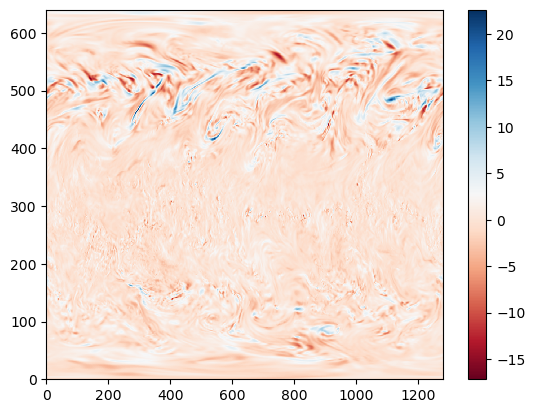

In [24]:
plt.pcolor(sample['x'][0,8,:,:]-sample['y'][1,0,8,:,:],cmap='RdBu')
plt.colorbar()
plt.show() 

In [25]:
dataset.data_array

<xarray.Dataset>
Dimensions:     (time: 8808, level: 15, latitude: 640, longitude: 1280,
                 half_level: 138)
Coordinates:
  * half_level  (half_level) int32 1 2 3 4 5 6 7 ... 132 133 134 135 136 137 138
  * latitude    (latitude) float64 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
  * level       (level) int32 10 30 40 50 60 70 80 90 95 100 105 110 120 130 136
  * longitude   (longitude) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * time        (time) datetime64[ns] 2010-01-01 ... 2011-01-02T23:00:00
Data variables:
    Q           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    SP          (time, latitude, longitude) float32 dask.array<chunksize=(10, 320, 640), meta=np.ndarray>
    T           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    U           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
    V           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 214, 427), meta=np.ndarray>
Attributes: (12/18)
    COMPUTATIONAL_PLATFORM:                 cheyenne supercomputer, NCAR-Wyom...
    COMPUTATIONAL_SPECIALIST:               Dave Stepaniak, NCAR/CISL/DECS, d...
    CONVERSION_AND_COMPRESSION_PLATFORM:    cheyenne node employed: Linux r2i...
    CONVERSION_AND_COMPRESSION_SPECIALIST:  Dave Stepaniak, NCAR/CISL/DECS, d...
    CONVERSION_AND_COMPRSSION_DATE:         Sat Dec 24 17:14:38 MST 2022
    Conventions:                            CF-1.6
    ...                                     ...
    NETCDF_VERSION:                         4.8.1
    RDA_DATASET:                            ds633.6
    RDA_DATASET_DOI:                        DOI: 10.5065/XV5R-5344
    RDA_DATASET_GROUP:                      ERA5 atmospheric model level anal...
    RDA_DATASET_URL:                        https:/rda.ucar.edu/datasets/ds63...
    history:                                Sat Dec 24 17:14:51 2022: ncks -4...

In [27]:
train_loader = torch.utils.data.DataLoader(dataset, 
                              batch_size=16) 
                              #shuffle=False, 
                              #pin_memory=True, 
                              #num_workers=0,
                              #drop_last=True)

In [ ]:
stuff = next(iter(train_loader))